In [1]:
import glob
import os
import json

from icecream import ic
import numpy as np
from mmcv import Config
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm  # Progress bar
from sklearn.metrics import confusion_matrix
import wandb
from torchmetrics.functional import f1_score, accuracy, precision, recall

from functions import create_train_validation_and_test_scene_list, get_model, get_loss, class_decider, compute_metrics, load_model
from loaders import get_variable_options, AI4ArcticChallengeTestDataset, AI4ArcticChallengeDataset

torch.set_num_threads(10)

metric_funcs = [f1_score, accuracy, precision, recall]

def load_model_cpu(net, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    net.load_state_dict(checkpoint['model_state_dict'])
    return net

/data1/antonk/miniconda/envs/mm_seaice/lib/python3.12/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/data1/antonk/miniconda/envs/mm_seaice/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
api = wandb.Api(api_key='e0912e764420c974191dc9a23c71fed3d683b2b9')
entity = 'korosov-nersc'
api_projects = api.projects(f'{entity}')

In [3]:
def to_nan(x):
    if x == 'NaN':
        return np.nan
    return x

hisotries = {}
for project in tqdm(api_projects, total=len(api_projects.objects), desc="WANDB"):
    runs = api.runs(f'{entity}/{project.name}')
    for run in runs:
        history = run.history()
        if len(history) == 0:
            continue
        for column in history.columns:
            if '_seg' in column:
                hisotries[f'{project.name} {run.name} {column}'] = history[column].to_numpy()

for name in hisotries.keys():
    hisotries[name] = np.array([to_nan(x) for x in list(hisotries[name])])

WANDB: 0it [00:00, ?it/s]

WANDB: 48it [01:01,  1.28s/it]


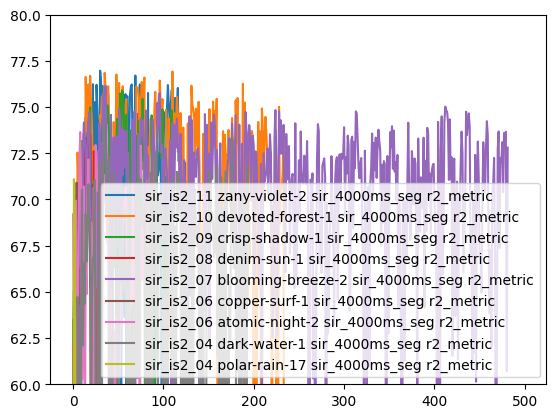

sir_is2_14 honest-universe-1 sir_1000ms_seg r2_metric 33.03900146484375 56
sir_is2_13 dry-moon-1 sir_4000ms_seg r2_metric 22.874000549316406 91
sir_is2_12 cosmic-pond-1 sir_4000ms_seg r2_metric 22.04599952697754 19
sir_is2_12 bumbling-energy-2 sir_4000ms_seg r2_metric 22.49799919128418 306
sir_is2_11 clean-wood-1 sir_4000ms_seg r2_metric 0 0
sir_is2_11 zany-violet-2 sir_4000ms_seg r2_metric 76.97000122070312 30
sir_is2_10 devoted-forest-1 sir_4000ms_seg r2_metric 76.9280014038086 110
sir_is2_09 crisp-shadow-1 sir_4000ms_seg r2_metric 75.90299987792969 54
sir_is2_08 denim-sun-1 sir_4000ms_seg r2_metric 73.4739990234375 19
sir_is2_07 blooming-breeze-2 sir_4000ms_seg r2_metric 76.14099884033203 36
sir_is2_06 copper-surf-1 sir_4000ms_seg r2_metric 70.91200256347656 4
sir_is2_06 atomic-night-2 sir_4000ms_seg r2_metric 73.64600372314453 8
sir_is2_05 sweet-sea-4 sir_1000ms_seg r2_metric -10.092000007629395 0
sir_is2_05 happy-fire-8 sir_1000ms_seg r2_metric 0.0 1
sir_is2_05 drawn-wildflower-10

In [4]:
max_hist = {}
max_idx = {}
for name in hisotries.keys():
    max_hist[name] = np.max(hisotries[name])
    max_idx[name] = np.argmax(hisotries[name])
    if max_hist[name] > 70:
        plt.plot(hisotries[name], label=name)
plt.ylim(60, 80)
plt.legend()
plt.show()
for name in max_hist.keys():
    print(name, max_hist[name], max_idx[name])

In [7]:
hisotries['sir_is2_11 clean-wood-1 sir_4000ms_seg r2_metric']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])